## Lazy Learning k-NN and ggplot2 - R style visuals

### Loading [Iris Dataset](https://archive.ics.uci.edu/ml/datasets/iris)

In [3]:
import pandas as pd
from plotnine import *   #plotnine enables us to use same syntax as ggplot2 to draw presentation ready plots
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('iris.csv')
print(df.shape)
df.head()

(150, 5)


,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


### Exploratory Data Analysis

In [5]:
df.describe(include='all')

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
count,150.000000,150.000000,150.000000,150.000000,150
unique,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,setosa
freq,NaN,NaN,NaN,NaN,50
mean,5.843333,3.057333,3.758000,1.199333,NaN
std,0.828066,0.435866,1.765298,0.762238,NaN
min,4.300000,2.000000,1.000000,0.100000,NaN
25%,5.100000,2.800000,1.600000,0.300000,NaN
50%,5.800000,3.000000,4.350000,1.300000,NaN
75%,6.400000,3.300000,5.100000,1.800000,NaN


#### mean and median are pretty close by for all variables, they are not skewed

In [6]:
df.groupby(['Species']).size()

Species
setosa        50
versicolor    50
virginica     50
dtype: int64

In [7]:
df.groupby(['Species']).mean().round(1)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Species,,,,
setosa,5.0,3.4,1.5,0.2
versicolor,5.9,2.8,4.3,1.3
virginica,6.6,3.0,5.6,2.0


#### Setosa's petal width is different from other two species, which can also be seen below as the distribution has two peaks, where the left one must be setosa

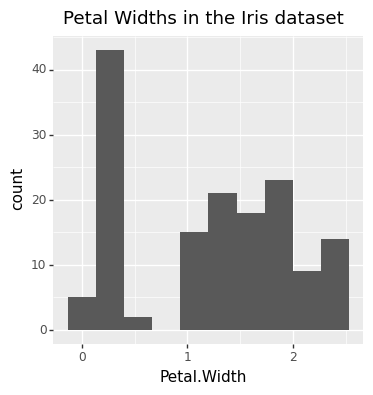

<ggplot: (151879328531)>

In [18]:
ggplot(df) + aes(x = 'Petal.Width') + \
geom_histogram(bins=10) + theme(figure_size=(4, 4)) + \
labs(title = 'Petal Widths in the Iris dataset')

#### Three types of flowers are also distinguishable in below plots

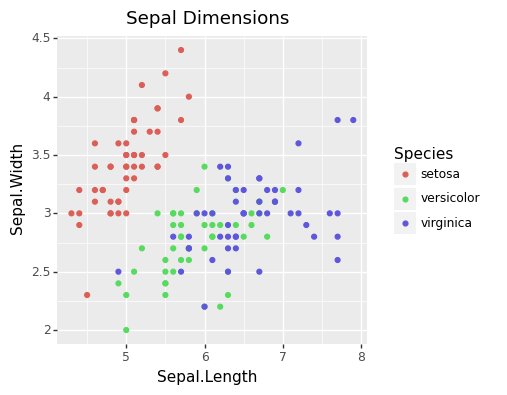

<ggplot: (151879449597)>

In [19]:
ggplot(df) + aes(x='Sepal.Length', y='Sepal.Width', color='Species') +\
geom_point() + theme(figure_size=(4, 4)) +\
labs(title = 'Sepal Dimensions')

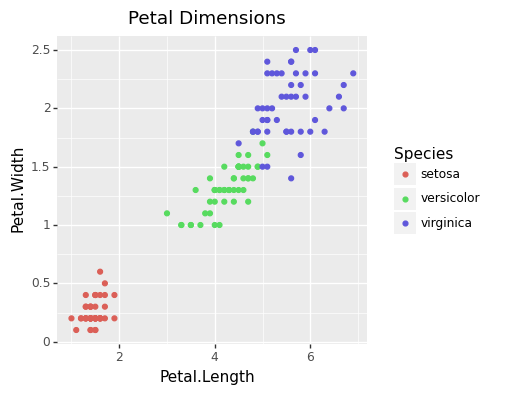

<ggplot: (151879458789)>

In [20]:
ggplot(df) + aes(x='Petal.Length', y='Petal.Width', color='Species') +\
geom_point() + theme(figure_size=(4, 4)) +\
labs(title = 'Petal Dimensions')

#### We do not observe any missing data

In [11]:
df.isna().sum()

Sepal.Length    0
Sepal.Width     0
Petal.Length    0
Petal.Width     0
Species         0
dtype: int64

### Using k-NN Classifier

**Points to note when using KNN:**
- k-NN classifier are model-free lazy-learners as they delay the process of modeling the training data until it is needed to classify the test instance 
- Classifying unknown records is expensive as the algorithm:
1. First, calculates the proximity or distance of the test datapoint to all the training datapoints to pick the top-k nearest datapoints
2. And then takes the majority vote of class labels by weighing the vote according to distance Eg: weight = 1/d^2
- As we are using euclidean distance here, we have to rescale features so that one feature doesn't end up dominating the distance calculation. Selecting appropriate proximity measure is required for the algorithm to work well.
- It can handle presence of interacting attributes by using proximity measures
- It has difficulty handling missing values as they are usually required for proximity calculation and redundant attributes can dominate the proximity calculation if present in large numbers 

#### Proximity between features can calculated by using several metrics:
1. For **Continous features**: the most common distance metric is the Minkowski Distance (Manhattan or L1 norm, Euclidean or L2 norm and L-infinity norm)
2. [Mahalanobis Distance](https://stats.stackexchange.com/questions/62092/bottom-to-top-explanation-of-the-mahalanobis-distance) can also be used, to consider the variance (scale) of different features and covariance among them. Using this metric is computationally expensive as it requires calculating the covariances as a scaling term.
3. For **Binary features**: Hamming Distance (which measures in how many positions are two vectors different), Simple matching coefficient[(#11 + #00)/(#01 + #10 + #11 + #00)], Jaccard[(#11)/(#01 + #10 + #11)]
4. For **Document similarity**: the most commonly used measure is cossine similarity as we use the # common words between documents to measure similarity and this metric is invariant to scaling and can handle non-binary counts.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']], df['Species'], test_size=0.2, random_state=1)

In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=3,
                          weights = 'distance'  #weight points by the inverse of their distance.
                          )
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
print(f"accuracy: {accuracy_score(y_test, pred)}")

accuracy: 1.0


### Parameter Tuning (k) using Cross Validation

In [26]:
from sklearn.model_selection import cross_val_score

# creating list of K for KNN
neighbors = list(range(1, 50, 2))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbors is 9


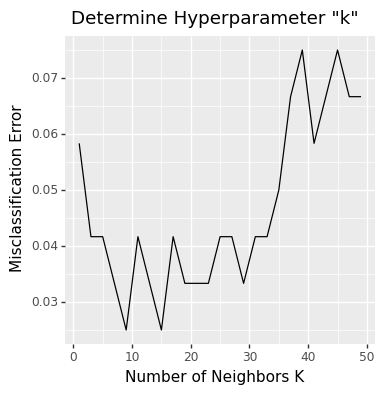

<ggplot: (151880563782)>

In [32]:
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print(f"The optimal number of neighbors is {optimal_k}")

ggplot() + aes(x=neighbors, y=mse) +\
geom_line() + theme(figure_size=(4, 4)) +\
labs(title = 'Determine Hyperparameter "k"',x = 'Number of Neighbors K',y = 'Misclassification Error')